<a href="https://colab.research.google.com/github/hafizhry/lymphoma-detection/blob/main/Pengenalan_Limfoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import package**

In [1]:
# Import package yang diperlukan
import os
import pathlib
import glob

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from os import getcwd

**2. Persiapan data yang akan digunakan**

In [2]:
# Import data
from google.colab import drive
drive.mount('/content/drive/')

%cd "/content/drive/.shortcut-targets-by-id/1w_btGZAxvZ4ODKQF0GWUDX_bKZrd_fB9/Paper Project/11-21_preprocessing"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1w_btGZAxvZ4ODKQF0GWUDX_bKZrd_fB9/Paper Project/11-21_preprocessing


In [20]:
# Penentuan directory data
#train_data_100_dir = '/data_enhanced/100x/train'
train_dir = 'data_enhanced/400x/train'
#test_data_100_dir = '/data_enhanced/100x/test'
test_dir = 'data_enhanced/400x/test'

train_data = pathlib.Path(train_dir)
test_data = pathlib.Path(test_dir)

train_BL_dir = os.path.join(train_dir, 'BL')
train_CA_dir = os.path.join(train_dir, 'CA')
train_LY_dir = os.path.join(train_dir, 'LY')

test_BL_dir = os.path.join(test_dir, 'BL')
test_CA_dir = os.path.join(test_dir, 'CA')
test_LY_dir = os.path.join(test_dir, 'LY')
jumlah_kelas = str(len(os.listdir(train_data)))

In [21]:
# Memperlihatkan jumlah data pada setiap kelas 
print('Jumlah kelas : ' + str(len(os.listdir(train_data))))
print('Jumlah data training')
print('BL : ' + str(len([name for name in os.listdir(train_BL_dir) if os.path.isfile(os.path.join(train_BL_dir, name))])))
print('CA : ' + str(len([name for name in os.listdir(train_CA_dir) if os.path.isfile(os.path.join(train_CA_dir, name))])))
print('LY : ' + str(len([name for name in os.listdir(train_LY_dir) if os.path.isfile(os.path.join(train_LY_dir, name))])))

print('Jumlah data test')
print('BL : ' + str(len([name for name in os.listdir(test_BL_dir) if os.path.isfile(os.path.join(test_BL_dir, name))])))
print('CA : ' + str(len([name for name in os.listdir(test_CA_dir) if os.path.isfile(os.path.join(test_CA_dir, name))])))
print('LY : ' + str(len([name for name in os.listdir(test_LY_dir) if os.path.isfile(os.path.join(test_LY_dir, name))])))

Jumlah kelas : 3
Jumlah data training
BL : 1094
CA : 893
LY : 1141
Jumlah data test
BL : 276
CA : 245
LY : 2629


In [22]:
# Hyperparameter untuk data
img_height = 224
img_width = 224
target_size = (img_height,img_width)
batch_size = 16
class_mode = 'sparse'
jumlah_kelas = jumlah_kelas


In [34]:
# Menyiapkan dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 42, 
    image_size = target_size,
    batch_size = batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42, 
    image_size = target_size,
    batch_size = batch_size
)

Found 3128 files belonging to 3 classes.
Using 2503 files for training.
Found 3128 files belonging to 3 classes.
Using 625 files for validation.


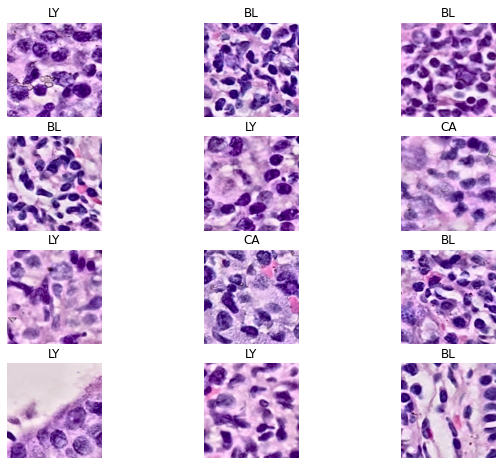

In [35]:
plt.figure(figsize = (10,8))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# # Menyiapkan data dengan melakukan augmentasi dan memasukkan ke generator
# train_datagen = ImageDataGenerator(rescale=1.0/255,)
#                                    #rotation_range = 90,
                                   
# test_datagen = ImageDataGenerator(rescale=1.0/255)

# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size = batch_size,
#                                                     class_mode = class_mode,
#                                                     target_size = target_size)
# validation_generator = train_datagen.flow_from_directory(test_dir,
#                                                     batch_size = batch_size,
#                                                     class_mode = class_mode,
#                                                     target_size = target_size)

**3. Persiapan model yang akan digunakan**

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
# Import model transfer learning
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

pre_trained_model = InceptionResNetV2(weights = 'imagenet',
                                      include_top = False, 
                                      input_shape = (img_height, img_width, 3))

for layer in pre_trained_model.layers:
  layer.trainable = False 


In [38]:
# Menggunakan preprocessing layer untuk data augmentation
data_augmentation = [
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomFlip('vertical'),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.Rescaling(1./255)
]

In [39]:
# Mendefinisikan classifier layer
classifier_layer = [
  layers.Conv2D(2048, 1, activation = 'relu', input_shape = (5, 5, 2048)),
  layers.GlobalAveragePooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),          
  layers.Dropout(0.25),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(jumlah_kelas, activation='softmax')
]

In [40]:
# Gabungan seluruh model 
model = Sequential() 
model.add(tf.keras.Input(shape = (img_height, img_width, 3)))
for layer in data_augmentation:
  model.add(layer)
model.add(pre_trained_model)
for layer in classifier_layer:
  model.add(layer)

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation_1 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 5, 5, 2048)       

**4. Pelatihan Model**

In [42]:
# Install RAdam
!pip install keras-rectified-adam
import keras_radam 
from keras_radam import RAdam

In [43]:
# Kompilasi model
model.compile(RAdam(), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
              metrics = ['acc'])

In [44]:
# Callback membatasi apabila training sudah mencapai akurasi maksimum
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'acc', patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath = 'model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only = True )
]


In [45]:
history = model.fit(train_data,
                    validation_data = val_data,
                    #steps_per_epoch = 100,
                    epochs = 300,
                    #validation_steps = 50,
                    #verbose = 2, 
                    callbacks = my_callbacks)

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


157/157 [==============================] - 495s 707ms/step - loss: 0.8925 - acc: 0.5637 - val_loss: 0.6850 - val_acc: 0.7136
Epoch 2/300
157/157 [==============================] - 20s 127ms/step - loss: 0.7217 - acc: 0.6848 - val_loss: 0.5474 - val_acc: 0.7840
Epoch 3/300
157/157 [==============================] - 21s 134ms/step - loss: 0.6241 - acc: 0.7399 - val_loss: 0.5796 - val_acc: 0.7680
Epoch 4/300
157/157 [==============================] - 20s 129ms/step - loss: 0.5958 - acc: 0.7607 - val_loss: 0.5242 - val_acc: 0.7888
Epoch 5/300
157/157 [==============================] - 21s 133ms/step - loss: 0.5734 - acc: 0.7759 - val_loss: 0.4224 - val_acc: 0.8528
Epoch 6/300
157/157 [==============================] - 20s 130ms/step - loss: 0.5251 - acc: 0.7994 - val_loss: 0.4641 - val_acc: 0.8160
Epoch 7/300
157/157 [==============================] - 20s 131ms/step - loss: 0.4711 - acc: 0.8174 - val_loss: 0.4646 - val_acc: 0.8320
Epoch 8/300
157/157 [==============================] - 21s 

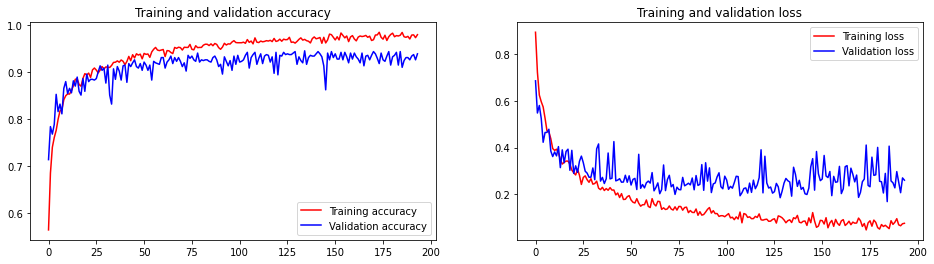

In [56]:
# Visualisasi hasil training model
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)



plt.show()

**5. Evaluasi Model**

In [47]:
# Definisi evaluation matrix
# Source https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


In [48]:
# Menyiapkan dataset untuk tes
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3150 files belonging to 3 classes.


In [49]:
# Membuat prediksi
label = []
scores = []
prediction = []

for images, labels in test_data.take(-1):
    for i in range(len(images)):
        img_array = keras.preprocessing.image.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        label.append(labels[i])
        scores.append(score)
        prediction.append(np.argmax(score))

In [50]:
confusion_matrix = tf.math.confusion_matrix(labels=label, predictions=prediction)
confusion_matrix = np.array(confusion_matrix)

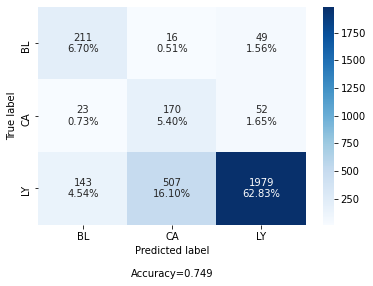

In [51]:
make_confusion_matrix(confusion_matrix, categories = ['BL', 'CA', 'LY'])

In [52]:
print('specificity')
print("BL: {}".format(confusion_matrix[1:2,1:2].sum()/confusion_matrix[1:2,:].sum()))
print("CA: {}".format((confusion_matrix[0,0]+confusion_matrix[0,2]+confusion_matrix[2,0]+confusion_matrix[2,2])/(confusion_matrix[0,:].sum()+confusion_matrix[2,:].sum())))
print("LY: {}".format(confusion_matrix[:1,:1].sum()/confusion_matrix[0:1,:].sum()))
print('sensitivity')
print("BL: {}".format(confusion_matrix[0,0]/confusion_matrix[0,:].sum()))
print("CA: {}".format(confusion_matrix[1,1]/confusion_matrix[1,:].sum()))
print("LY: {}".format(confusion_matrix[2,2]/confusion_matrix[2,:].sum()))

specificity
BL: 0.6938775510204082
CA: 0.8199655765920826
LY: 0.7644927536231884
sensitivity
BL: 0.7644927536231884
CA: 0.6938775510204082
LY: 0.7527577025484975


In [57]:
model.save(os.path.join('models','-model'))

INFO:tensorflow:Assets written to: models/-model/assets
